# <center> Проект: регрессия

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import tree 
from sklearn import ensemble as ens
from sklearn import metrics as m
from sklearn import cluster as c
from sklearn import feature_selection as fs

## 1. Знакомство с данными

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


In [2]:
data = pd.read_csv('data/Project5_train_data.zip')

data

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
0               -73.964630         40.765602                  N            455  
1               -73.999481         40.731152                  N            663  
2               -74.005333         40.710087                  N           2124  
3               -74.012268         40.706718                  N            429  
4               -73.972923         40.782520                  N            435  
...                    ...               ...                ...            ...  
1458639         -73.994911         40.740170                  N            778  
1458640         -73.970184         40.796547                  N            655  
1458641         -74.004433         40.707371                  N            764  
1458642         -73.974632         40.757107                  N            373  
1458643         -73.972809         40.790585                  N            198  

[1458644 rows x 11 columns]

---

In [3]:
# переведем временные признаки в формат даты-времени

data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

data[['pickup_datetime', 'dropoff_datetime']].sort_values(by='pickup_datetime')

pickup_datetime    dropoff_datetime
96469   2016-01-01 00:00:17 2016-01-01 00:14:26
223872  2016-01-01 00:00:53 2016-01-01 00:22:27
713067  2016-01-01 00:01:01 2016-01-01 00:07:49
652463  2016-01-01 00:01:14 2016-01-01 00:05:54
722901  2016-01-01 00:01:20 2016-01-01 00:13:36
...                     ...                 ...
853710  2016-06-30 23:58:52 2016-07-01 00:06:44
419031  2016-06-30 23:59:09 2016-07-01 00:11:43
1008720 2016-06-30 23:59:10 2016-07-01 00:41:36
405743  2016-06-30 23:59:37 2016-07-01 00:23:39
500524  2016-06-30 23:59:39 2016-07-01 00:43:08

[1458644 rows x 2 columns]

In [4]:
# проверим, есть ли в данных пропуски

data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

> Пропусков в наших данных нет.

---

In [5]:
# добавим отдельные признаки даты, часа и дня недели включения счетчика, 
# вероятно больше всего поездок совершается утром, вечером и в конце недели

def add_datetime_features(data):
    data['pickup_date'] = pd.to_datetime(data['pickup_datetime'].dt.date)
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_of_week
    
    return data

data = add_datetime_features(data)

data[['pickup_date', 'pickup_hour', 'pickup_day_of_week']]

pickup_date  pickup_hour  pickup_day_of_week
0        2016-03-14           17                   0
1        2016-06-12            0                   6
2        2016-01-19           11                   1
3        2016-04-06           19                   2
4        2016-03-26           13                   5
...             ...          ...                 ...
1458639  2016-04-08           13                   4
1458640  2016-01-10            7                   6
1458641  2016-04-22            6                   4
1458642  2016-01-05           15                   1
1458643  2016-04-05           14                   1

[1458644 rows x 3 columns]

---

In [6]:
# нам понадобятся дополнительные данные о праздниках, 
# так как много поездок могут быть именно в эти дни

holidays = pd.read_csv('data/holiday_data.csv', sep=';')

holidays

day        date                     holiday
0     Friday  2016-01-01               New Years Day
1     Monday  2016-01-18  Martin Luther King Jr. Day
2     Friday  2016-02-12          Lincoln's Birthday
3     Monday  2016-02-15             Presidents' Day
4     Sunday  2016-05-08                Mother's Day
5     Monday  2016-05-30                Memorial Day
6     Sunday  2016-06-19                Father's Day
7     Monday  2016-07-04            Independence Day
8     Monday  2016-09-05                   Labor Day
9     Monday  2016-10-10                Columbus Day
10    Friday  2016-11-11                Veterans Day
11  Thursday  2016-11-24                Thanksgiving
12    Monday  2016-12-26     Christmas Day (in lieu)
13   Tuesday  2016-11-08                Election Day

In [7]:
# добавим признак-флаг, была ли совершена поездка в праздничный день

def add_holiday_features(data, holidays):
    holidays['date'] = pd.to_datetime(holidays['date'])
    data_hols = data.merge(holidays, how='left', left_on='pickup_date', right_on='date').fillna(0)
    data['pickup_holiday'] = data_hols['holiday'].apply(lambda d: 1 if d != 0 else d)
    
    return data

data = add_holiday_features(data, holidays)

data['pickup_holiday']

0          0
1          0
2          0
3          0
4          0
          ..
1458639    0
1458640    0
1458641    0
1458642    0
1458643    0
Name: pickup_holiday, Length: 1458644, dtype: int64

---

In [8]:
# нам нужны данные о местоположениях каждой машины во время поездки

osrm = pd.read_csv('data/osrm_data_train.zip')

osrm

id               starting_street              end_street  \
0        id2875421               Columbus Circle        East 65th Street   
1        id2377394                    2nd Avenue  Washington Square West   
2        id3504673              Greenwich Street                Broadway   
3        id2181028                      Broadway        West 81st Street   
4        id0801584              Lexington Avenue        West 31st Street   
...            ...                           ...                     ...   
1458638  id2976426                   Cargo Plaza        East 51st Street   
1458639  id1440046  Former Terminal 6 Departures              3rd Avenue   
1458640  id1607338                   Cargo Plaza         West 8th Street   
1458641  id2071901                   Cargo Plaza   Laurel Hill Boulevard   
1458642  id0995846         Terminal 8 departures       West 106th Street   

         total_distance  total_travel_time  number_of_steps  \
0                2009.1              164.9                5   
1                2513.2              332.0                6   
2                1779.4              235.8                4   
3                1614.9              140.1                5   
4                1393.5              189.4                5   
...                 ...                ...              ...   
1458638         28051.1             1462.5               13   
1458639         29616.3             1643.2               16   
1458640         25615.0             1765.1               30   
1458641         20284.1             1074.3               14   
1458642         30302.5             1675.8               20   

                                      street_for_each_step  \
0        Columbus Circle|Central Park West|65th Street ...   
1        2nd Avenue|East 13th Street|5th Avenue|Washing...   
2            Greenwich Street|Park Place|Broadway|Broadway   
3        Broadway|West 86th Street|Columbus Avenue|West...   
4        Lexington Avenue|East 27th Street|Madison Aven...   
...                                                    ...   
1458638  Cargo Plaza|Cargo Plaza|Van Wyck Expressway|Ca...   
1458639  Former Terminal 6 Departures|Cargo Plaza|Cargo...   
1458640  Cargo Plaza|Cargo Plaza|Cargo Plaza|Cargo Plaz...   
1458641  Cargo Plaza|Cargo Plaza|Cargo Plaza|Van Wyck E...   
1458642  Terminal 8 departures|Cargo Plaza|Cargo Plaza|...   

                                         distance_per_step  \
0                                    0|576.4|885.6|547.1|0   
1                          877.3|836.5|496.1|164.2|139.1|0   
2                                      644.2|379.9|755.3|0   
3                                  617|427.4|412.2|158.3|0   
4                                 18.9|311.9|313.3|749.4|0   
...                                                    ...   
1458638  145.4|1039|12154.4|931.8|6422.3|3745.6|2032.5|...   
1458639  110.2|415.2|895.1|12154.4|931.8|6422.3|1686.5|...   
1458640  179.5|66.3|314.8|431.8|1557.5|266.3|454.7|604|...   
1458641  124.3|535.2|895.1|12154.4|931.8|1521.6|573.1|3...   
1458642  493.4|436.6|238.9|8759.3|703.1|3806.4|5006.7|1...   

                                      travel_time_per_step  \
0                                       0|61.1|60.1|43.7|0   
1                               111.7|109|69.9|25.8|15.6|0   
2                                        80.5|50.8|104.5|0   
3                                        56|36|37.8|10.3|0   
4                                     6.3|42.9|48.4|91.8|0   
...                                                    ...   
1458638  21|82.8|489.4|57.2|359.5|164.1|139.9|14.4|2.9|...   
1458639  15.9|63.9|71.6|489.4|57.2|359.5|81.8|19.4|10.3...   
1458640  28|9.5|25.2|34.5|62|21.3|36.6|24.1|25.2|238.2|...   
1458641  22|79|71.6|489.4|57.2|85.4|45.9|28.5|22.2|9.5|...   
1458642  73|64.8|19|350|56.3|152.4|200.6|115.1|81.1|179...   

                                            step_maneuvers  \
0                       depart|rotary|turn|new na

In [9]:
# соединим основную таблицу со столбцами из дополнительной: 
# идентификатор поездки, пройденное расстояние, затраченное время, количество смен направления

def add_osrm_features(data, osrm):
    data = pd.merge(data, osrm[['id', 
                                'total_distance', 
                                'total_travel_time', 
                                'number_of_steps']], how='left', on='id')
    
    return data

data = add_osrm_features(data, osrm)

data

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458639         -73.994911         40.740170                  N   
1458640         -73.970184         40.796547                  N   
1458641         -74.004433         40.707371                  N   
1458642         -73.974632         40.757107                  N   
1458643         -73.972809         40.790585                  N   

         trip_duration pickup_date  pickup_hour  pickup_day_of_week  \
0                  455  2016-03-14           17                   0   
1                  663  2016-06-12            0                   6   
2                 2124  2016-01-19           11                   1   
3                  429  2016-04-06           19                   2   
4                  435  2016-03-26           13                   5   
...                ...         ...          ...                 ...   
1458639            778  2016-04-08           13                   4   
1458640            655  2016-01-10            7                   6   
1458641            764  2016-04-22            6                   4   
1458642            373  2016-01-05           15                   1   
1458643            198  2016-04-05           14                   1   

         pickup_holiday  total_distance  total_travel_time  number_of_steps  
0                     0          2009.1              164.9              5.0  
1                     0          2513.2              332.0              6.0  
2                     0         11060.8              767.6             16.0  
3                     0          1779.4              235.8              4.0  
4                     0          1614.9              140.1              5.0  
...                 ...             ...                ...              ...  
1458639               0          2234.6              311.7              8.0  
1458640               0          7638.0              589.6             11.0  
1458641               

---

In [10]:
# нужно рассчитать расстояние от точки начала маршрута до точки его конца, 
# мы будем это делать по формуле Хаверсина и формуле угла направления

def add_geographical_features(data):
    
    def get_haversine_distance(lat1, lng1, lat2, lng2):
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        EARTH_RADIUS = 6371 

        lat_delta = lat2 - lat1
        lng_delta = lng2 - lng1
        
        d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
        h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
        
        return h

    def get_angle_direction(lat1, lng1, lat2, lng2):
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        lng_delta_rad = lng2 - lng1
        
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
        y = np.sin(lng_delta_rad) * np.cos(lat2)
        
        alpha = np.degrees(np.arctan2(y, x))
        
        return alpha
    
    data['haversine_distance'] = get_haversine_distance(data['pickup_latitude'], 
                                                        data['pickup_longitude'], 
                                                        data['dropoff_latitude'], 
                                                        data['dropoff_longitude'])

    data['direction'] = get_angle_direction(data['pickup_latitude'], 
                                            data['pickup_longitude'], 
                                            data['dropoff_latitude'], 
                                            data['dropoff_longitude'])
    
    return data


data = add_geographical_features(data)

data[['haversine_distance', 'direction']]

haversine_distance   direction
0                  1.498521   99.970196
1                  1.805507 -117.153768
2                  6.385098 -159.680165
3                  1.485498 -172.737700
4                  1.188588  179.473585
...                     ...         ...
1458639            1.225080 -119.059338
1458640            6.049836   25.342196
1458641            7.824606 -150.788492
1458642            1.092564   35.033294
1458643            1.134042   29.969486

[1458644 rows x 2 columns]

---

In [11]:
# создадим кластеры географических координат, приблизительно соответствующие районам Нью-Йорка

def add_cluster_features(data):
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                        data[['dropoff_latitude', 'dropoff_longitude']]))

    # обучаем алгоритм кластеризации
    kmeans = c.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)

    data['geo_cluster'] = kmeans.predict(coords)
    
    return data

data = add_cluster_features(data)

data['geo_cluster']

0          9
1          4
2          4
3          4
4          9
          ..
1458639    0
1458640    9
1458641    4
1458642    0
1458643    9
Name: geo_cluster, Length: 1458644, dtype: int32

---

In [12]:
# нам нужны данные о погодных условиях которые также влияют на продолжительность поездки

weather = pd.read_csv('data/weather_data.zip')

weather

time  temperature  windchill  heat index  humidity  \
0     2015-12-31 02:00:00          7.8        7.1         NaN      0.89   
1     2015-12-31 03:00:00          7.2        5.9         NaN      0.90   
2     2015-12-31 04:00:00          7.2        NaN         NaN      0.90   
3     2015-12-31 05:00:00          7.2        5.9         NaN      0.86   
4     2015-12-31 06:00:00          7.2        6.4         NaN      0.90   
...                   ...          ...        ...         ...       ...   
8782  2017-01-01 21:00:00          5.0        3.3         NaN      0.43   
8783  2017-01-01 22:00:00          5.6        3.6         NaN      0.38   
8784  2017-01-01 23:00:00          5.6        4.0         NaN      0.38   
8785  2017-01-02 00:00:00          5.0        3.3         NaN      0.41   
8786  2017-01-02 01:00:00          5.0        2.1         NaN      0.43   

      pressure  dew Point  visibility  wind dir  wind speed  gust speed  \
0       1017.0        6.1         8.0       NNE         5.6         0.0   
1       1016.5        5.6        12.9  Variable         7.4         0.0   
2       1016.7        5.6        12.9      Calm         0.0         0.0   
3       1015.9        5.0        14.5        NW         7.4         0.0   
4       1016.2        5.6        11.3      West         5.6         0.0   
...        ...        ...         ...       ...         ...         ...   
8782    1028.5       -6.7        16.1       ENE         7.4         0.0   
8783    1029.3       -7.8        16.1        NE         9.3         0.0   
8784    1030.2       -7.8        16.1        NE         7.4         0.0   
8785    1030.6       -7.2        16.1       ENE         7.4         0.0   
8786    1030.1       -6.7        16.1       ENE        13.0         0.0   

      precip events conditions        date  hour  
0        0.8   None   Overcast  2015-12-31     2  
1        0.3   None   Overcast  2015-12-31     3  
2        0.0   None   Overcast  2015-12-31     4  
3        0.0   None   Overcast  2015-12-31     5  
4        0.0   None   Overcast  2015-12-31     6  
...      ...    ...        ...         ...   ...  
8782     0.0   None      Clear  2017-01-01    21  
8783     0.0   None      Clear  2017-01-01    22  
8784     0.0   None      Clear  2017-01-01    23  
8785     0.0   None      Clear  2017-01-02     0  
8786     0.0   None      Clear  2017-01-02     1  

[8787 rows x 16 columns]

In [13]:
# добавляем в основную таблицу столбцы о температуре воздуха, видимости, скорости ветра,
# количестве осадков и том, какие погодные явления были во время поездки

def add_weather_features(data, weather):
    weather['date'] = pd.to_datetime(weather['date'])

    data = pd.merge(data, weather[['temperature', 'visibility', 
                                'wind speed', 'precip', 
                                'events', 'date', 'hour']], 
                    left_on=['pickup_date', 'pickup_hour'], 
                    right_on=['date', 'hour'], how='left').drop(['date', 'hour'], axis=1)
    
    return data

data = add_weather_features(data, weather)

data

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  \
0               -73.964630         40.765602                  N  ...   
1               -73.999481         40.731152                  N  ...   
2               -74.005333         40.710087                  N  ...   
3               -74.012268         40.706718                  N  ...   
4               -73.972923         40.782520                  N  ...   
...                    ...               ...                ...  ...   
1458639         -73.994911         40.740170                  N  ...   
1458640         -73.970184         40.796547                  N  ...   
1458641         -74.004433         40.707371                  N  ...   
1458642         -73.974632         40.757107                  N  ...   
1458643         -73.972809         40.790585                  N  ...   

         total_travel_time number_of_steps  haversine_distance   direction  \
0                    164.9             5.0            1.498521   99.970196   
1                    332.0             6.0            1.805507 -117.153768   
2                    767.6            16.0            6.385098 -159.680165   
3                    235.8             4.0            1.485498 -172.737700   
4                    140.1             5.0            1.188588  179.473585   
...                    ...             ...                 ...         ...   
1458639              311.7             8.0            1.225080 -119.059338   
1458640              589.6            11.0            6.049836   25.342196   
1458641              642.9            10.0            7.824606 -150.788492   
1458642              161.6             7.0            1.092564   35.033294   
1458643               90.7             2.0            1.134042   29.969486   

         geo_cluster  temperature  visibility  wind speed  precip  events  
0                  9          4.4         8.0        27.8     0.3    None  
1                  4         28.9        16.1         7.4     0.0    None  
2                  4         -6.7        16.1        24.1     0.0    None  
3                  4          7.2        16.1        25.9     0.0    None  
4                  9          9.4        16.1         9.3     0.0    None  
...              ...          ...         ...         ...     ...     ...  
1458639            0          7.8        16.1   

---

In [14]:
# в данных появились пропуски, поэтому числовые признаки заполняем их медианным значением, 
# а категориальные - словом None

def fill_null_weather_data(data):
    for col in data.columns:
        if data[col].dtypes in (int, float):
            data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))
        else:
            data[col] = data[col].fillna(value='None')
            
    return data

data = fill_null_weather_data(data)

data

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  \
0               -73.964630         40.765602                  N  ...   
1               -73.999481         40.731152                  N  ...   
2               -74.005333         40.710087                  N  ...   
3               -74.012268         40.706718                  N  ...   
4               -73.972923         40.782520                  N  ...   
...                    ...               ...                ...  ...   
1458639         -73.994911         40.740170                  N  ...   
1458640         -73.970184         40.796547                  N  ...   
1458641         -74.004433         40.707371                  N  ...   
1458642         -73.974632         40.757107                  N  ...   
1458643         -73.972809         40.790585                  N  ...   

         total_travel_time number_of_steps  haversine_distance   direction  \
0                    164.9             5.0            1.498521   99.970196   
1                    332.0             6.0            1.805507 -117.153768   
2                    767.6            16.0            6.385098 -159.680165   
3                    235.8             4.0            1.485498 -172.737700   
4                    140.1             5.0            1.188588  179.473585   
...                    ...             ...                 ...         ...   
1458639              311.7             8.0            1.225080 -119.059338   
1458640              589.6            11.0            6.049836   25.342196   
1458641              642.9            10.0            7.824606 -150.788492   
1458642              161.6             7.0            1.092564   35.033294   
1458643               90.7             2.0            1.134042   29.969486   

         geo_cluster  temperature  visibility  wind speed  precip  events  
0                  9          4.4         8.0        27.8     0.3    None  
1                  4         28.9        16.1         7.4     0.0    None  
2                  4         -6.7        16.1        24.1     0.0    None  
3                  4          7.2        16.1        25.9     0.0    None  
4                  9          9.4        16.1         9.3     0.0    None  
...              ...          ...         ...         ...     ...     ...  
1458639            0          7.8        16.1   

---

In [15]:
# избавляемся от выбросов в данных тем, что в них не должно быть
# поездок с длительностью больше 24 часов и средней скоростью больше 300 км/ч

avg_speed = data['total_distance'] / data['trip_duration'] * 3.6

data = data[data['trip_duration'] <= (3600*24)]
data = data[avg_speed <= 300]

data

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  \
0               -73.964630         40.765602                  N  ...   
1               -73.999481         40.731152                  N  ...   
2               -74.005333         40.710087                  N  ...   
3               -74.012268         40.706718                  N  ...   
4               -73.972923         40.782520                  N  ...   
...                    ...               ...                ...  ...   
1458639         -73.994911         40.740170                  N  ...   
1458640         -73.970184         40.796547                  N  ...   
1458641         -74.004433         40.707371                  N  ...   
1458642         -73.974632         40.757107                  N  ...   
1458643         -73.972809         40.790585                  N  ...   

         total_travel_time number_of_steps  haversine_distance   direction  \
0                    164.9             5.0            1.498521   99.970196   
1                    332.0             6.0            1.805507 -117.153768   
2                    767.6            16.0            6.385098 -159.680165   
3                    235.8             4.0            1.485498 -172.737700   
4                    140.1             5.0            1.188588  179.473585   
...                    ...             ...                 ...         ...   
1458639              311.7             8.0            1.225080 -119.059338   
1458640              589.6            11.0            6.049836   25.342196   
1458641              642.9            10.0            7.824606 -150.788492   
1458642              161.6             7.0            1.092564   35.033294   
1458643               90.7             2.0            1.134042   29.969486   

         geo_cluster  temperature  visibility  wind speed  precip  events  
0                  9          4.4         8.0        27.8     0.3    None  
1                  4         28.9        16.1         7.4     0.0    None  
2                  4         -6.7        16.1        24.1     0.0    None  
3                  4          7.2        16.1        25.9     0.0    None  
4                  9          9.4        16.1         9.3     0.0    None  
...              ...          ...         ...         ...     ...     ...  
1458639            0          7.8        16.1   

---

## 2. Разведывательный анализ данных (EDA)

<AxesSubplot: >

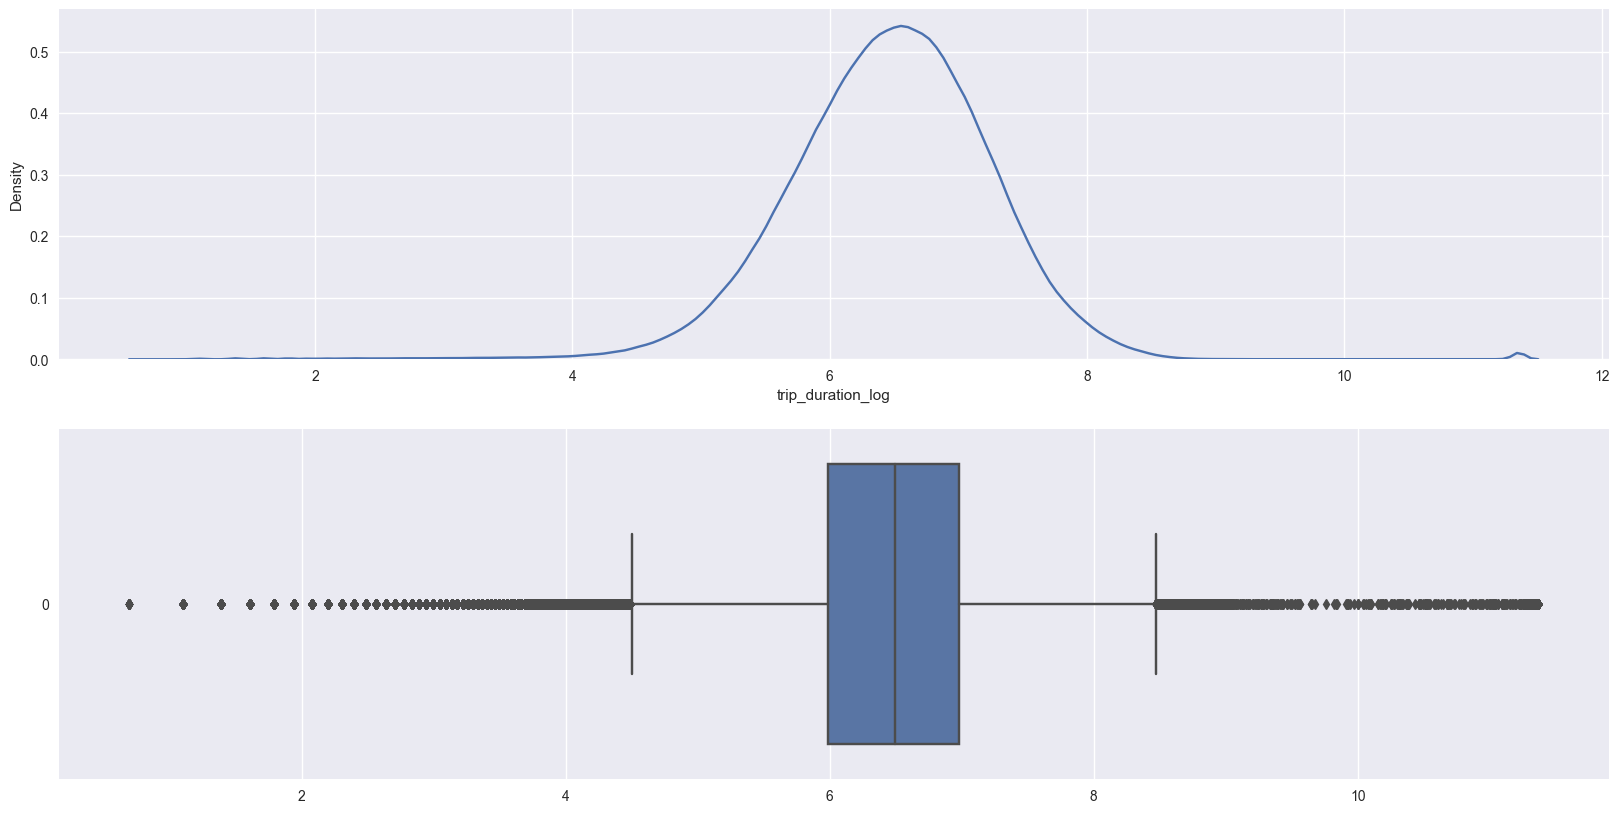

In [16]:
# для удобства переведем целевой признак в логарифмический масштаб 
# и посмотрим на его распределение

data['trip_duration_log'] = np.log(data['trip_duration']+1)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.kdeplot(data['trip_duration_log'], ax=ax[0])
sns.boxplot(data['trip_duration_log'], orient='h', ax=ax[1])

> Распределение не похоже на нормальное, так как в данных много выбросов (несмотря на логарифмирование).

In [17]:
# чтобы проверить распределение на нормальность, нужно провести тест, 
# в данном случае - тест д'Агостино и сравним полученный p-value с уровнем значимости - 0.05

H0 = 'Распределение нормальное'
H1 = 'Распределение ненормальное'

_, pv = st.normaltest(data['trip_duration_log'])

if pv > 0.05:
    print(H0)
else:
    print(H1)

pv

Распределение ненормальное


0.0

> Тест подтвердил, что распределение нормальным не является.

<AxesSubplot: xlabel='trip_duration_log', ylabel='Density'>

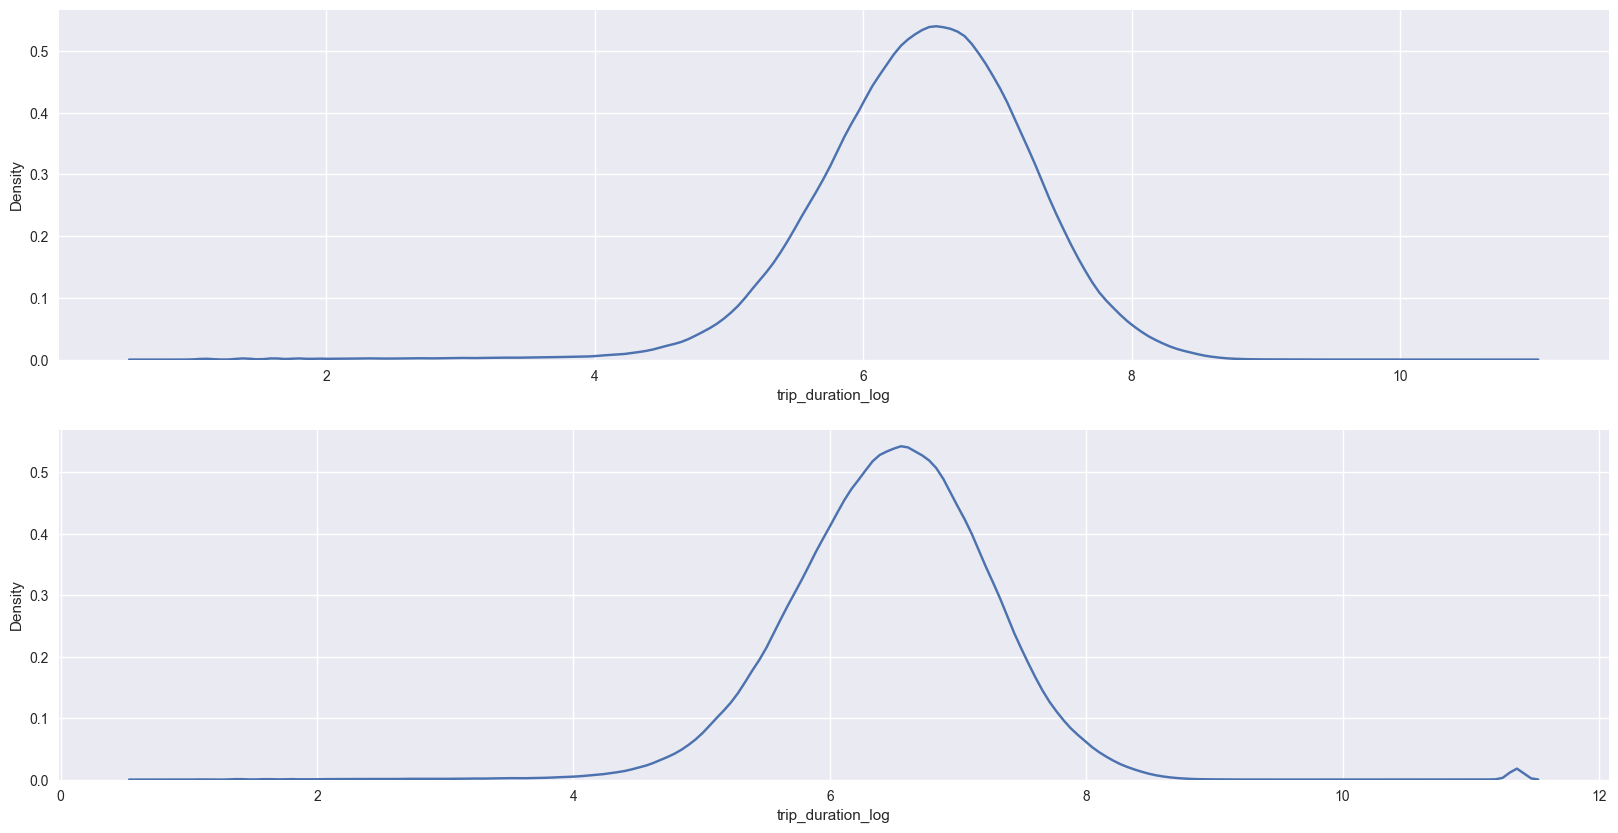

In [18]:
# посмотрим на распределение длительности поездки в зависимости от таксопарка

fig, ax = plt.subplots(2, 1, figsize=(20, 10)) 

sns.kdeplot(data[data['vendor_id'] == 1]['trip_duration_log'], ax=ax[0])
sns.kdeplot(data[data['vendor_id'] == 2]['trip_duration_log'], ax=ax[1])

> Продолжительность поездки не зависит от таксопарка, так как гистограммы выглядят примерно одинаково.

<AxesSubplot: xlabel='trip_duration_log', ylabel='Density'>

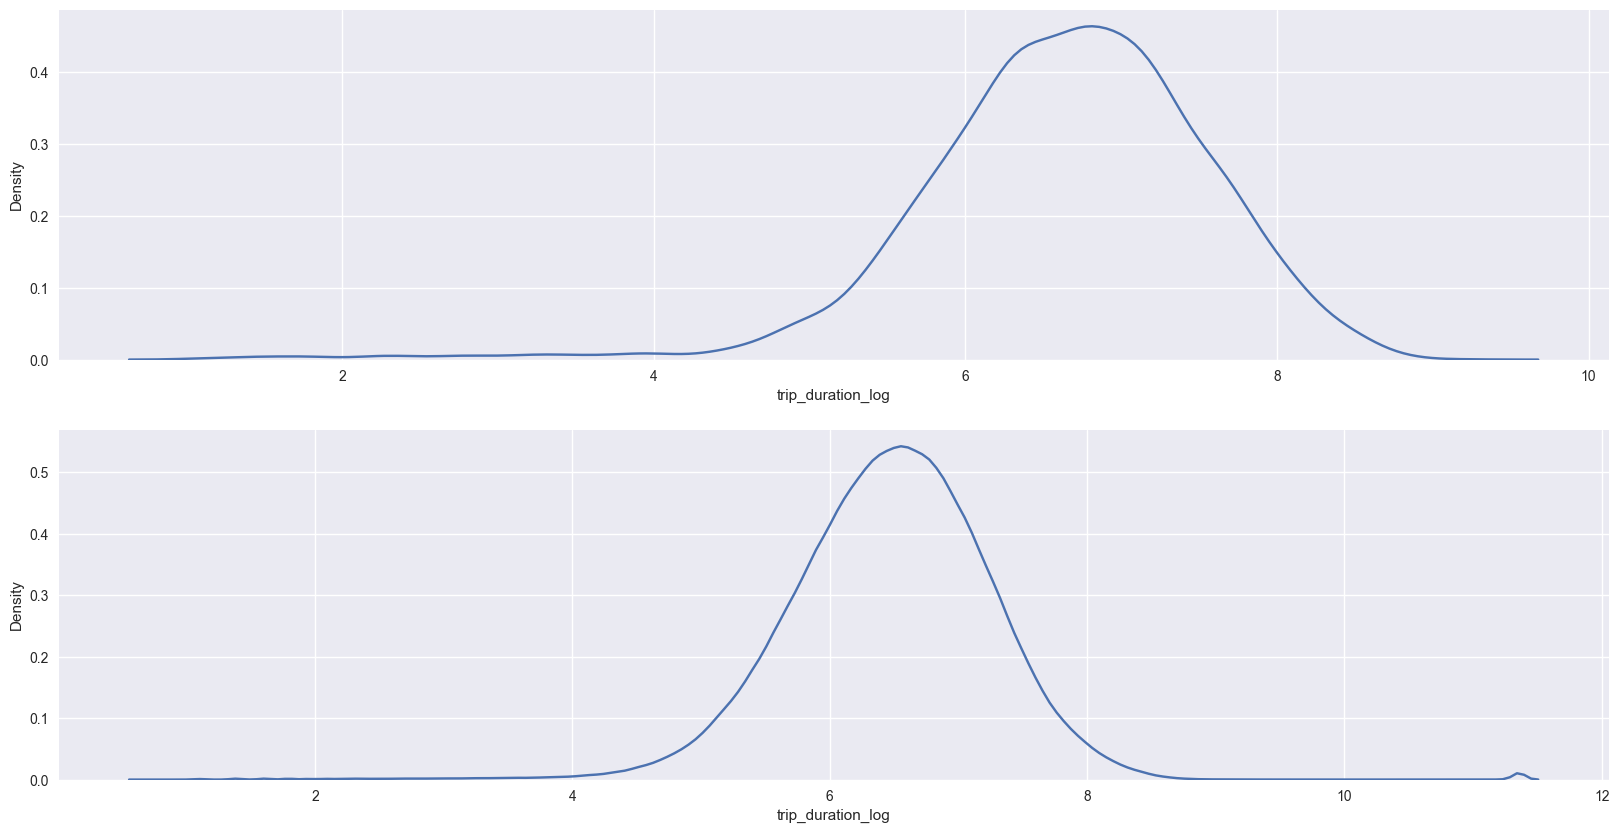

In [19]:
# посмотрим на распределение признака в зависимости от того,
# сохранилась ли запись о поездке в памяти счетчика

fig, ax = plt.subplots(2, 1, figsize=(20, 10)) 

sns.kdeplot(data[data['store_and_fwd_flag'] == 'Y']['trip_duration_log'], ax=ax[0])
sns.kdeplot(data[data['store_and_fwd_flag'] == 'N']['trip_duration_log'], ax=ax[1])

> 

<AxesSubplot: xlabel='pickup_hour', ylabel='trip_duration_log'>

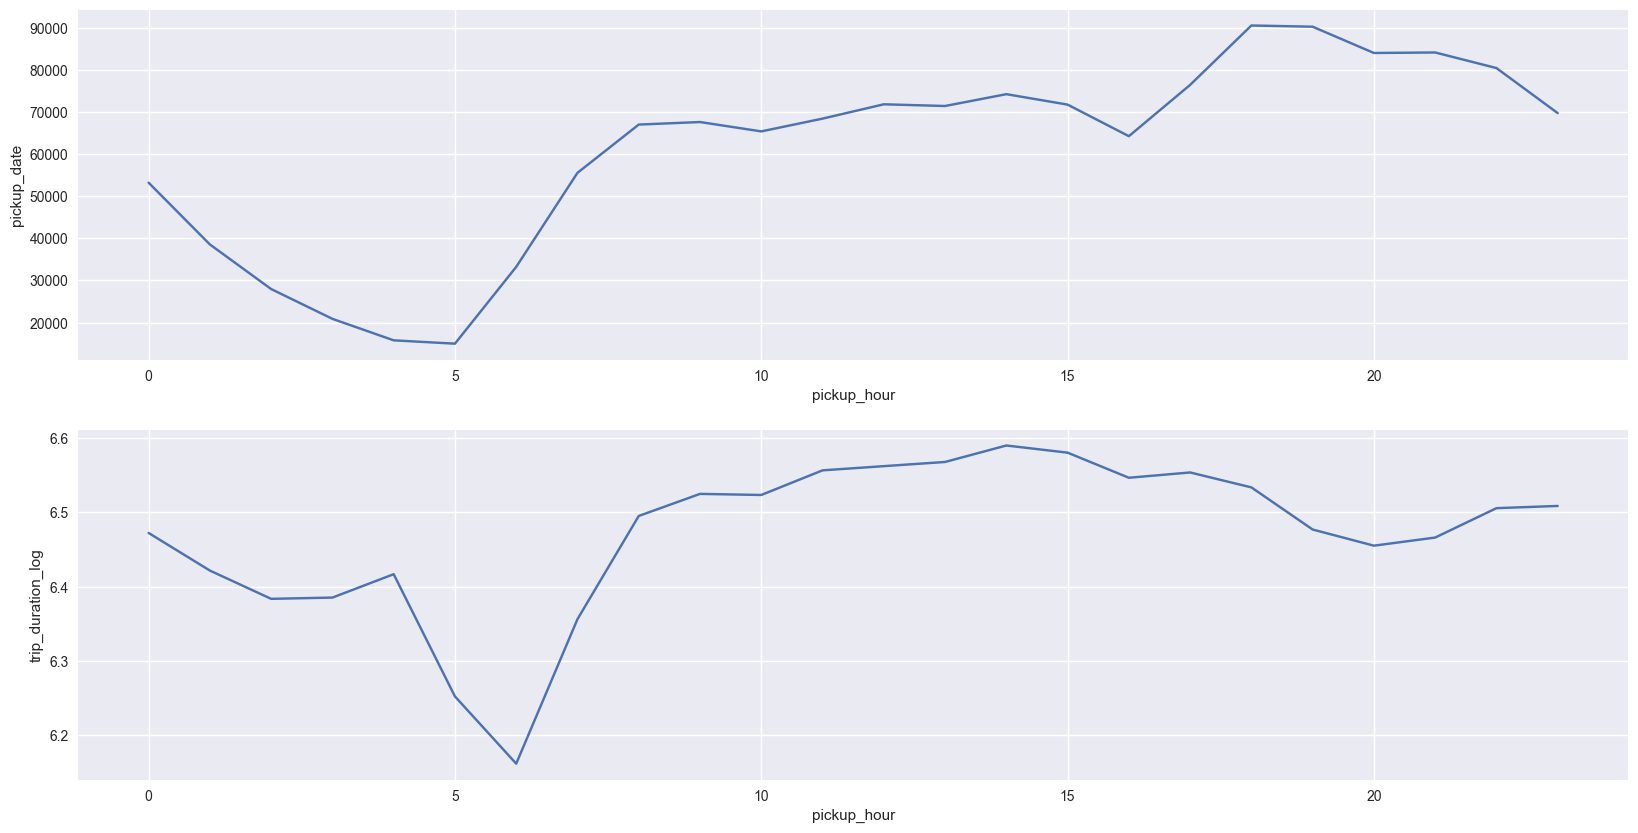

In [20]:
# в какие часы происходит больше всего поездок 
# и в какое время они были самыми продолжительными

hourcnt = data.groupby('pickup_hour', as_index=False)['pickup_date'].count()
hourmed = data.groupby('pickup_hour', as_index=False)['trip_duration_log'].median()

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(hourcnt, x='pickup_hour', y='pickup_date', ax=ax[0])
sns.lineplot(hourmed, x='pickup_hour', y='trip_duration_log', ax=ax[1])

<AxesSubplot: xlabel='pickup_day_of_week', ylabel='trip_duration_log'>

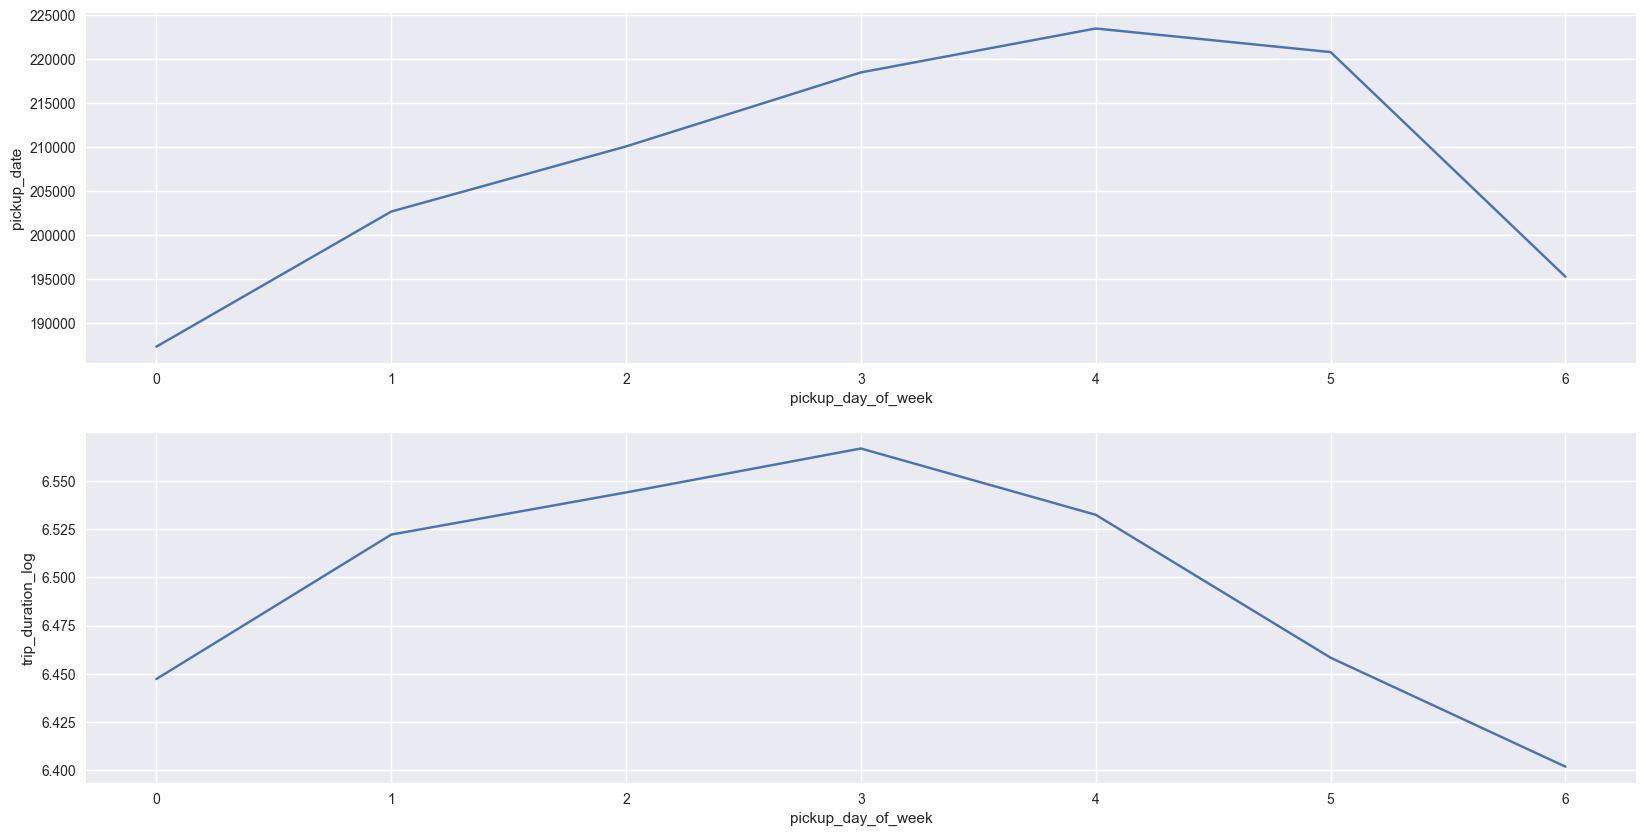

In [21]:
# в какие дни недели было больше всего поездок 
# и в какие дни они были самыми продолжительными

weekcnt = data.groupby('pickup_day_of_week', as_index=False)['pickup_date'].count()
weekmed = data.groupby('pickup_day_of_week', as_index=False)['trip_duration_log'].median()

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(weekcnt, x='pickup_day_of_week', y='pickup_date', ax=ax[0])
sns.lineplot(weekmed, x='pickup_day_of_week', y='trip_duration_log', ax=ax[1])

<AxesSubplot: xlabel='pickup_day_of_week', ylabel='pickup_hour'>

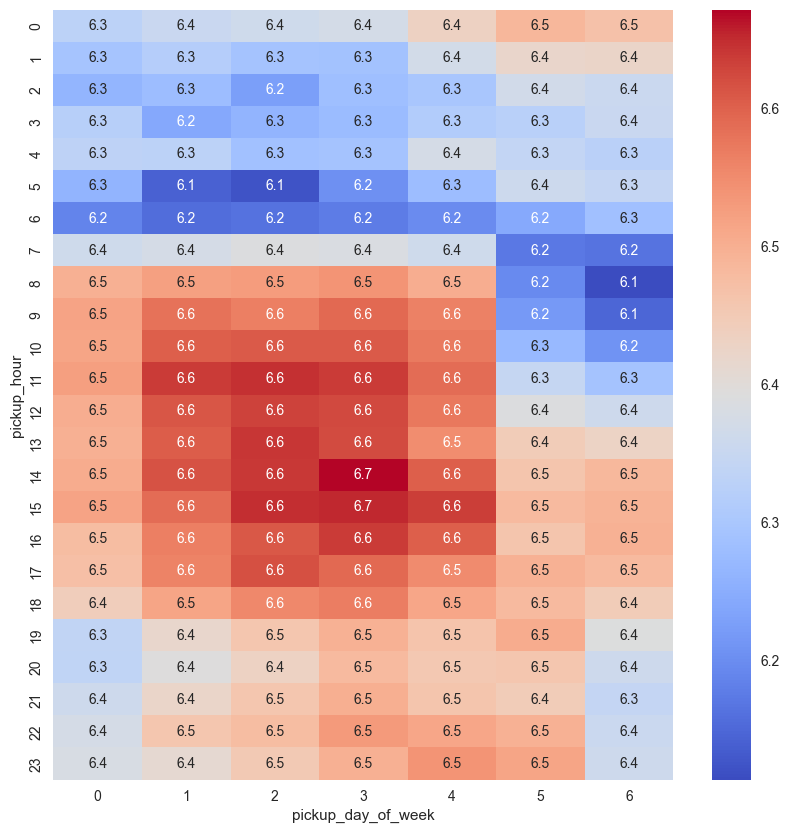

In [22]:
# посмотрим на обе характеристики дня недели и часа дня 
# в контексте их влияния на продолжительность поездки вместе

data_pivo = data.pivot_table(index='pickup_hour', 
                             columns='pickup_day_of_week', 
                             values='trip_duration_log')

plt.figure(figsize=(10, 10))
sns.heatmap(data_pivo, cmap='coolwarm', annot=True)

In [23]:
# очистим данные от поездок с координатами начала и конца маршрута за пределами Нью-Йорка

newyork_data = data[data['pickup_longitude'].between(-74.03, -73.75) &
                    data['pickup_latitude'].between(40.63, 40.85) & 
                    data['dropoff_longitude'].between(-74.03, -73.75) &
                    data['dropoff_latitude'].between(40.63, 40.85)]

newyork_data

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  \
0               -73.964630         40.765602                  N  ...   
1               -73.999481         40.731152                  N  ...   
2               -74.005333         40.710087                  N  ...   
3               -74.012268         40.706718                  N  ...   
4               -73.972923         40.782520                  N  ...   
...                    ...               ...                ...  ...   
1458639         -73.994911         40.740170                  N  ...   
1458640         -73.970184         40.796547                  N  ...   
1458641         -74.004433         40.707371                  N  ...   
1458642         -73.974632         40.757107                  N  ...   
1458643         -73.972809         40.790585                  N  ...   

         number_of_steps haversine_distance   direction  geo_cluster  \
0                    5.0           1.498521   99.970196            9   
1                    6.0           1.805507 -117.153768            4   
2                   16.0           6.385098 -159.680165            4   
3                    4.0           1.485498 -172.737700            4   
4                    5.0           1.188588  179.473585            9   
...                  ...                ...         ...          ...   
1458639              8.0           1.225080 -119.059338            0   
1458640             11.0           6.049836   25.342196            9   
1458641             10.0           7.824606 -150.788492            4   
1458642              7.0           1.092564   35.033294            0   
1458643              2.0           1.134042   29.969486            9   

         temperature  visibility  wind speed  precip  events  \
0                4.4         8.0        27.8     0.3    None   
1               28.9        16.1         7.4     0.0    None   
2               -6.7        16.1        24.1     0.0    None   
3                7.2        16.1        25.9     0.0    None   
4                9.4        16.1         9.3     0.0    None   
...              ...         ...         ...     ...     ...   
1458639          7.8        16.1        11.1     0.0    None   
1458640          7.2         2.8        18.5     8.1    Rain   
1458641         18.3        16.1         0.0     0.0    None   
1458642     

<AxesSubplot: xlabel='pickup_longitude', ylabel='pickup_latitude'>

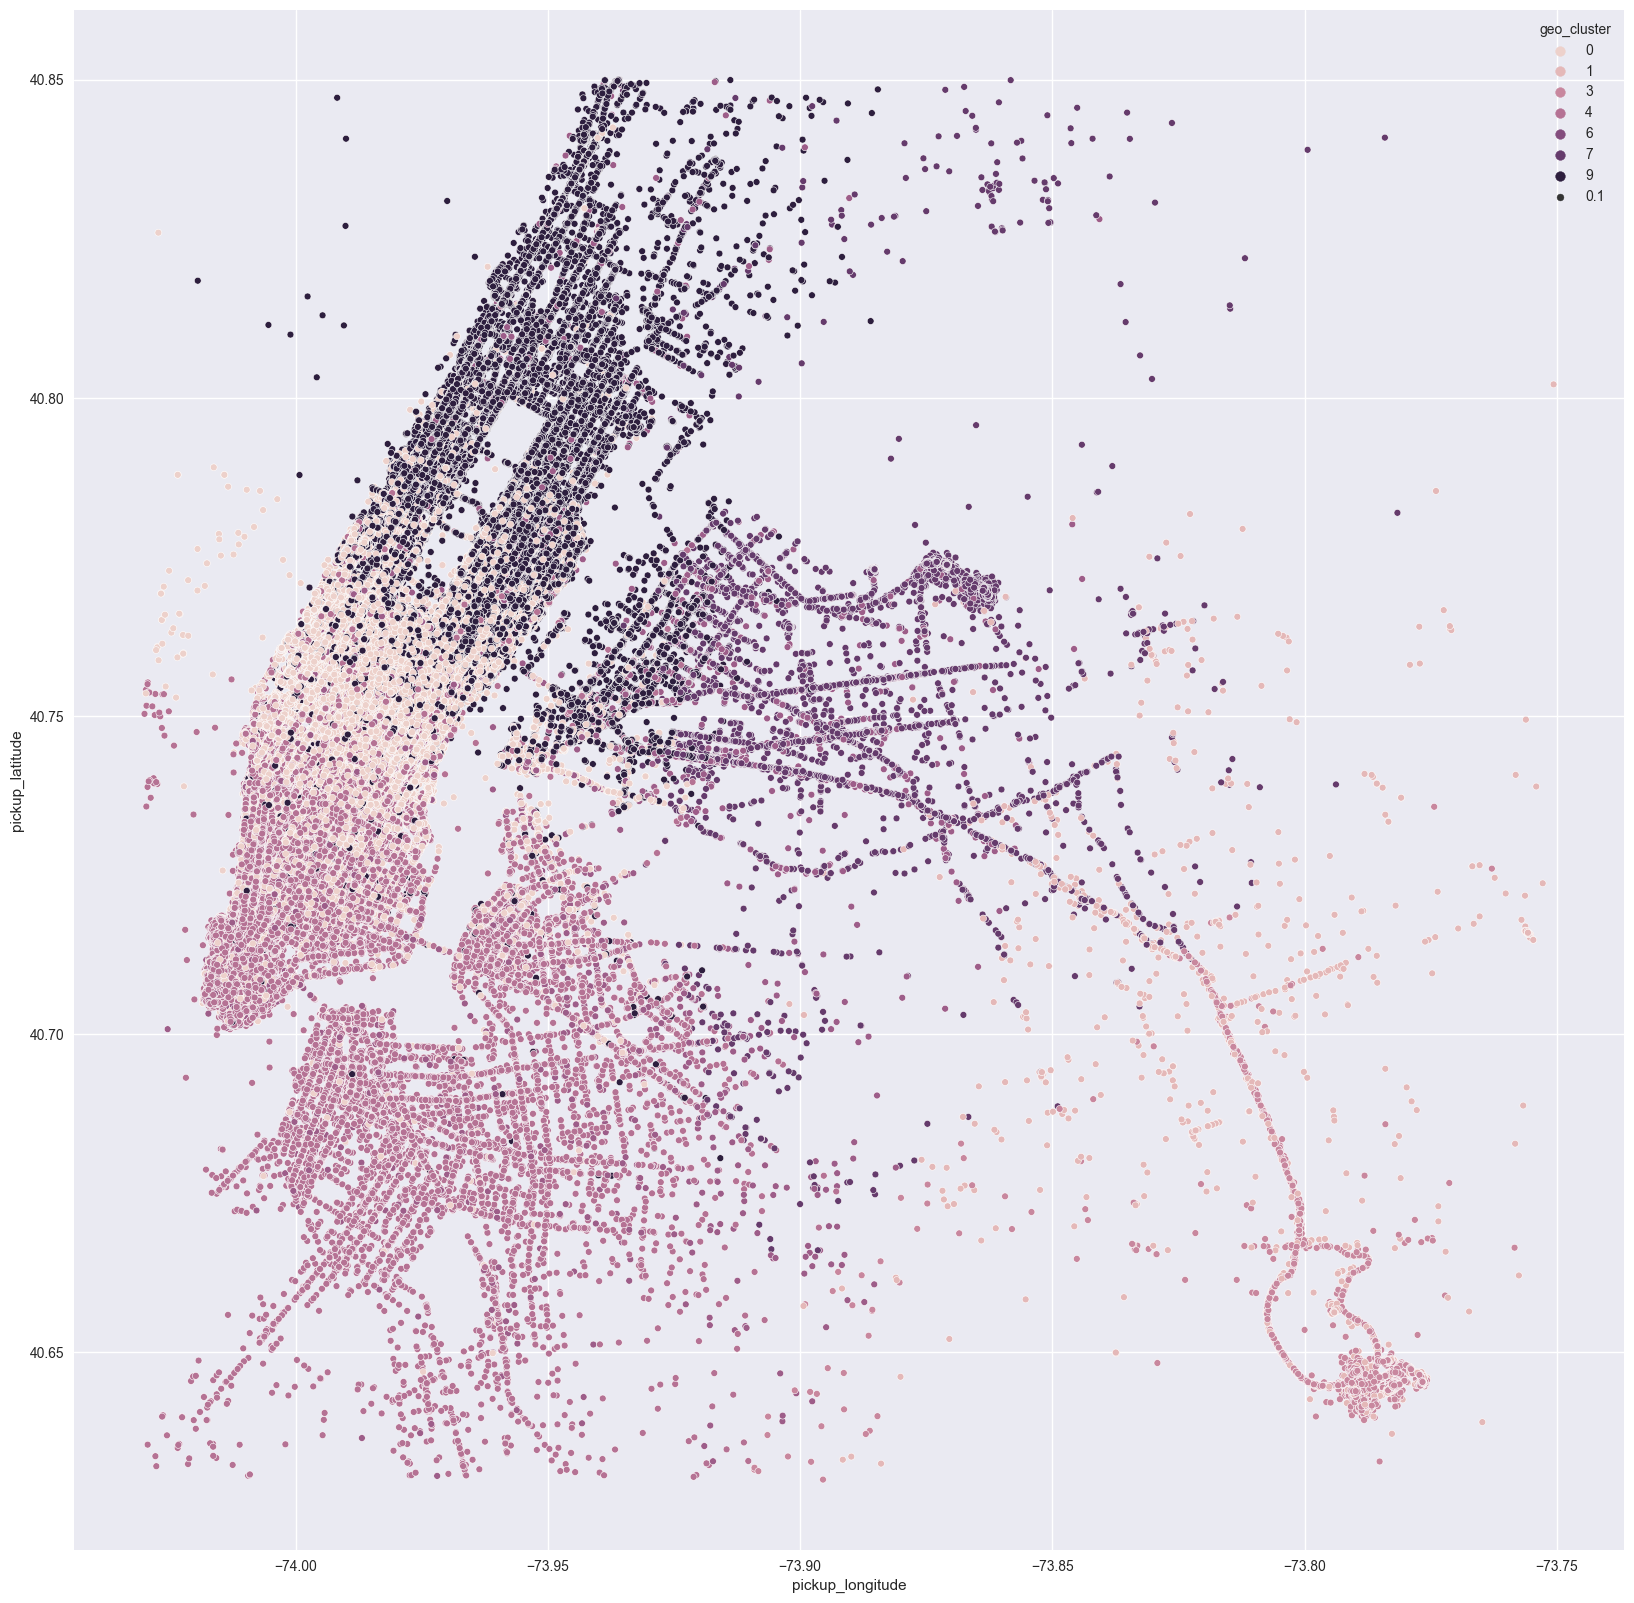

In [24]:
# построим диаграмму рассеяния, чтобы узнать, какие кластеры не попали на карту Нью-Йорка
# 1 - рассеяние точек начала маршрута

plt.figure(figsize=(20, 20))
sns.scatterplot(newyork_data, 
                x='pickup_longitude', 
                y='pickup_latitude', 
                hue='geo_cluster', 
                size=0.1)

<AxesSubplot: xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

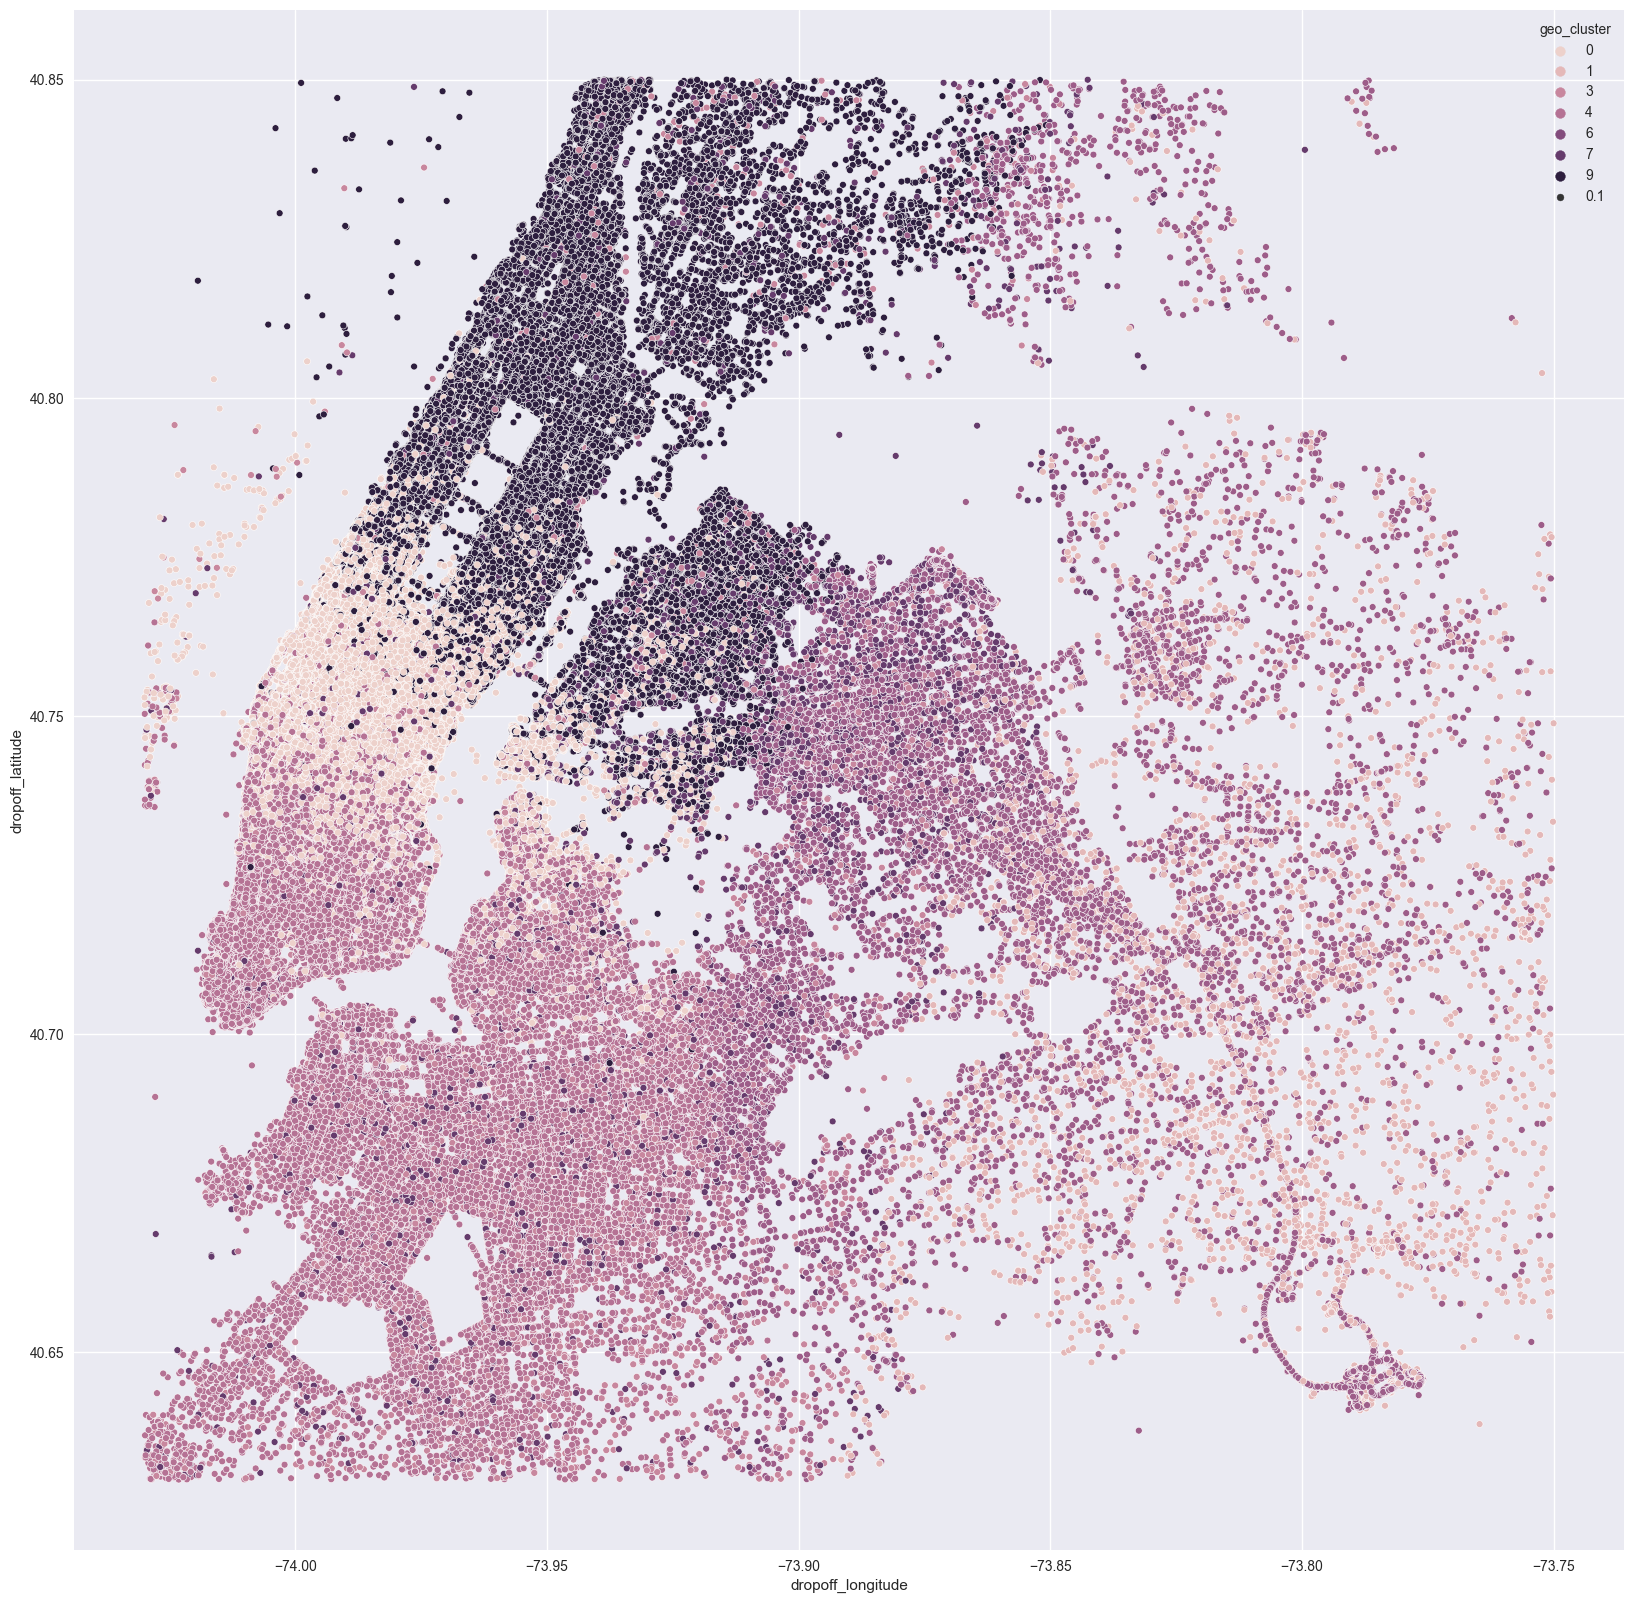

In [25]:
# 2 - рассеяние точек конца маршрута

plt.figure(figsize=(20, 20))
sns.scatterplot(newyork_data, 
                x='dropoff_longitude', 
                y='dropoff_latitude', 
                hue='geo_cluster', 
                size=0.1) 

## 3. Отбор и преобразование признаков

In [26]:
print(f'Shape of data: {data.shape}')
print(f'Columns: {data.columns}') 

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


In [27]:
train_data = data.copy()

train_data = train_data.drop(['id', 
                              'pickup_datetime', 
                              'dropoff_datetime', 
                              'pickup_date'], axis=1).reset_index(drop=True)

train_data

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0                2                1        -73.982155        40.767937   
1                1                1        -73.980415        40.738564   
2                2                1        -73.979027        40.763939   
3                2                1        -74.010040        40.719971   
4                2                1        -73.973053        40.793209   
...            ...              ...               ...              ...   
1458228          2                4        -73.982201        40.745522   
1458229          1                1        -74.000946        40.747379   
1458230          2                1        -73.959129        40.768799   
1458231          1                1        -73.982079        40.749062   
1458232          1                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458228         -73.994911         40.740170                  N   
1458229         -73.970184         40.796547                  N   
1458230         -74.004433         40.707371                  N   
1458231         -73.974632         40.757107                  N   
1458232         -73.972809         40.790585                  N   

         trip_duration  pickup_hour  pickup_day_of_week  ...  number_of_steps  \
0                  455           17                   0  ...              5.0   
1                  663            0                   6  ...              6.0   
2                 2124           11                   1  ...             16.0   
3                  429           19                   2  ...              4.0   
4                  435           13                   5  ...              5.0   
...                ...          ...                 ...  ...              ...   
1458228            778           13                   4  ...              8.0   
1458229            655            7                   6  ...             11.0   
1458230            764            6                   4  ...             10.0   
1458231            373           15                   1  ...              7.0   
1458232            198           14                   1  ...              2.0   

         haversine_distance   direction  geo_cluster  temperature  visibility  \
0                  1.498521   99.970196            9          4.4         8.0   
1                  1.805507 -117.153768            4         28.9        16.1   
2                  6.385098 -159.680165            4         -6.7        16.1   
3                  1.485498 -172.737700            4          7.2        16.1   
4                  1.188588  179.473585            9          9.4        16.1   
...                     ...         ...          ...          ...         ...   
1458228            1.225080 -119.059338            0          7.8        16.1   
1458229            6.049836   25.342196            9          7.2         2.8   
1458230            7.824606 -150.788492            4         18.3        16.1   
1458231            1.092564   35.033294            0         -2.8        16.1   
1458232            1.134042   29.969486            9          2.2        16.1   

         wind speed  precip  events  trip_duration_log  
0              27.8     0.3    None           6.122493  
1               7.4     0.0    None           6.498282  
2              24.1     0.0    None           7.661527  
3              25.9     0.0    None           6.063785  
4               9.3     0.0    None           6.077642  
...             ...     ...

In [28]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda v: 0 if v == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda f: 0 if f == 'N' else 1)

train_data[['vendor_id', 'store_and_fwd_flag']] 

vendor_id  store_and_fwd_flag
0                1                   0
1                0                   0
2                1                   0
3                1                   0
4                1                   0
...            ...                 ...
1458228          1                   0
1458229          0                   0
1458230          1                   0
1458231          0                   0
1458232          0                   0

[1458233 rows x 2 columns]

In [29]:
train_data['vendor_id'].mean().round(2), train_data['store_and_fwd_flag'].mean().round(3)

(0.53, 0.006)

In [30]:
data_onehot = train_data[['pickup_day_of_week', 'geo_cluster', 'events']]

ohe = pp.OneHotEncoder(drop='first', sparse_output=False)
ohe.fit(data_onehot)

data_onehot_enc = ohe.transform(data_onehot)

column_names = ohe.get_feature_names_out()
data_onehot_enc = pd.DataFrame(data_onehot_enc, columns=column_names)

data_onehot_enc

pickup_day_of_week_1  pickup_day_of_week_2  pickup_day_of_week_3  \
0                         0.0                   0.0                   0.0   
1                         0.0                   0.0                   0.0   
2                         1.0                   0.0                   0.0   
3                         0.0                   1.0                   0.0   
4                         0.0                   0.0                   0.0   
...                       ...                   ...                   ...   
1458228                   0.0                   0.0                   0.0   
1458229                   0.0                   0.0                   0.0   
1458230                   0.0                   0.0                   0.0   
1458231                   1.0                   0.0                   0.0   
1458232                   1.0                   0.0                   0.0   

         pickup_day_of_week_4  pickup_day_of_week_5  pickup_day_of_week_6  \
0                         0.0                   0.0                   0.0   
1                         0.0                   0.0                   1.0   
2                         0.0                   0.0                   0.0   
3                         0.0                   0.0                   0.0   
4                         0.0                   1.0                   0.0   
...                       ...                   ...                   ...   
1458228                   1.0                   0.0                   0.0   
1458229                   0.0                   0.0                   1.0   
1458230                   1.0                   0.0                   0.0   
1458231                   0.0                   0.0                   0.0   
1458232                   0.0                   0.0                   0.0   

         geo_cluster_1  geo_cluster_2  geo_cluster_3  geo_cluster_4  \
0                  0.0            0.0            0.0            0.0   
1                  0.0            0.0            0.0            1.0   
2                  0.0            0.0            0.0            1.0   
3                  0.0            0.0            0.0            1.0   
4                  0.0            0.0            0.0            0.0   
...                ...            ...            ...            ...   
1458228            0.0            0.0            0.0            0.0   
1458229            0.0            0.0            0.0            0.0   
1458230            0.0            0.0            0.0            1.0   
1458231            0.0            0.0            0.0            0.0   
1458232            0.0            0.0            0.0            0.0   

         geo_cluster_5  geo_cluster_6  geo_cluster_7  geo_cluster_8  \
0                  0.0            0.0            0.0            0.0   
1                  0.0            0.0            0.0            0.0   
2                  0.0            0.0            0.0            0.0   
3                  0.0            0.0            0.0            0.0   
4                  0.0            0.0            0.0            0.0   
...                ...            ...            ...            ...   
1458228            0.0            0.0            0.0            0.0   
1458229            0.0            0.0            0.0            0.0   
1458230            0.0            0.0            0.0            0.0   
1458231            0.0            0.0            0.0            0.0   
1458232            0.0            0.0            0.0            0.0   

         geo_cluster_9  events_None  events_Rain  events_Snow  
0                  1.0          1.0          0.0          0.0  
1                  0.0          1.0          0.0          0.0  
2                  0.0          1.0          0.0          0.0  
3                  0.0          1.0          0.0          0.0  
4                  1.0          1.0          0.0          0.0  
...                ...          ...          ...          ...  
14582

In [31]:
train_data = pd.concat([train_data.drop(data_onehot.columns.tolist(), axis=1), 
                        data_onehot_enc], axis=1)

train_data

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0                1                1        -73.982155        40.767937   
1                0                1        -73.980415        40.738564   
2                1                1        -73.979027        40.763939   
3                1                1        -74.010040        40.719971   
4                1                1        -73.973053        40.793209   
...            ...              ...               ...              ...   
1458228          1                4        -73.982201        40.745522   
1458229          0                1        -74.000946        40.747379   
1458230          1                1        -73.959129        40.768799   
1458231          0                1        -73.982079        40.749062   
1458232          0                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  \
0               -73.964630         40.765602                   0   
1               -73.999481         40.731152                   0   
2               -74.005333         40.710087                   0   
3               -74.012268         40.706718                   0   
4               -73.972923         40.782520                   0   
...                    ...               ...                 ...   
1458228         -73.994911         40.740170                   0   
1458229         -73.970184         40.796547                   0   
1458230         -74.004433         40.707371                   0   
1458231         -73.974632         40.757107                   0   
1458232         -73.972809         40.790585                   0   

         trip_duration  pickup_hour  pickup_holiday  ...  geo_cluster_3  \
0                  455           17               0  ...            0.0   
1                  663            0               0  ...            0.0   
2                 2124           11               0  ...            0.0   
3                  429           19               0  ...            0.0   
4                  435           13               0  ...            0.0   
...                ...          ...             ...  ...            ...   
1458228            778           13               0  ...            0.0   
1458229            655            7               0  ...            0.0   
1458230            764            6               0  ...            0.0   
1458231            373           15               0  ...            0.0   
1458232            198           14               0  ...            0.0   

         geo_cluster_4  geo_cluster_5  geo_cluster_6  geo_cluster_7  \
0                  0.0            0.0            0.0            0.0   
1                  1.0            0.0            0.0            0.0   
2                  1.0            0.0            0.0            0.0   
3                  1.0            0.0            0.0            0.0   
4                  0.0            0.0            0.0            0.0   
...                ...            ...            ...            ...   
1458228            0.0            0.0            0.0            0.0   
1458229            0.0            0.0            0.0            0.0   
1458230            1.0            0.0            0.0            0.0   
1458231            0.0            0.0            0.0            0.0   
1458232            0.0            0.0            0.0            0.0   

         geo_cluster_8  geo_cluster_9  events_None  events_Rain  events_Snow  
0                  0.0            1.0          1.0          0.0          0.0  
1                  0.0            0.0          1.0          0.0          0.0  
2                  0.0            0.0          1.0          0.0          0.0  
3                  0.0            0.0          1.0          0.0          0.0  
4                  0.0            1.0          1.0          0.0          0.0  
...                ...            ...          ...          ...          ..

In [32]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

X_train, X_valid, y_train_log, y_valid_log = ms.train_test_split(X, y_log, test_size=0.33, random_state=42)

X_train.shape, X_valid.shape, y_train_log.shape, y_valid_log.shape

((977016, 36), (481217, 36), (977016,), (481217,))

In [33]:
skb = fs.SelectKBest(score_func=fs.f_regression, k=25) 
skb.fit(X_train, y_train_log)

skb_feats = skb.get_feature_names_out()

X_train = X_train[skb_feats]
X_valid = X_valid[skb_feats]

skb_feats

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

In [34]:
mm_scaler = pp.MinMaxScaler()
mm_scaler.fit(X_train, y_train_log)

X_train = pd.DataFrame(mm_scaler.transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(mm_scaler.transform(X_valid), columns=X_valid.columns)

In [35]:
X_valid.iloc[:, 0].mean().round(2) 

0.54

## 4. Решение задачи регрессии: линейная регрессия и деревья решений

In [36]:
rmsle = lambda y, y_: round((m.mean_squared_error(y, y_))**0.5, 2)

In [37]:
lin = lm.LinearRegression()
lin.fit(X_train, y_train_log)

ypred_tr = lin.predict(X_train)
ypred_vl = lin.predict(X_valid)

rmsle(y_train_log, ypred_tr), rmsle(y_valid_log, ypred_vl)

(0.54, 0.54)

In [38]:
pols = pp.PolynomialFeatures(degree=2, include_bias=False)
pols.fit(X_train, y_train_log)

X_train_pols = pols.transform(X_train)
X_valid_pols = pols.transform(X_valid)

lin.fit(X_train_pols, y_train_log)

ypred_tr = lin.predict(X_train_pols)
ypred_vl = lin.predict(X_valid_pols)

rmsle(y_train_log, ypred_tr), rmsle(y_valid_log, ypred_vl)

In [ ]:
ridge = lm.Ridge() 
ridge.fit(X_train_pols, y_train_log)

ypred_tr = ridge.predict(X_train_pols)
ypred_vl = ridge.predict(X_valid_pols)

rmsle(y_train_log, ypred_tr), rmsle(y_valid_log, ypred_vl)

(0.48, 0.48)

In [ ]:
dtree = tree.DecisionTreeRegressor(random_state=42) 
dtree.fit(X_train, y_train_log)

ypred_tr = dtree.predict(X_train)
ypred_vl = dtree.predict(X_valid)

rmsle(y_train_log, ypred_tr), rmsle(y_valid_log, ypred_vl)

(0.0, 0.57)

In [ ]:
max_depths = range(7, 20)

train_scores = []
valid_scores = []

for depth in max_depths:
    dtree = tree.DecisionTreeRegressor(max_depth=depth, random_state=42) 
    dtree.fit(X_train, y_train_log)

    ypred_tr = dtree.predict(X_train)
    ypred_vl = dtree.predict(X_valid)
    
    train_scores.append(rmsle(y_train_log, ypred_tr))
    valid_scores.append(rmsle(y_valid_log, ypred_vl))

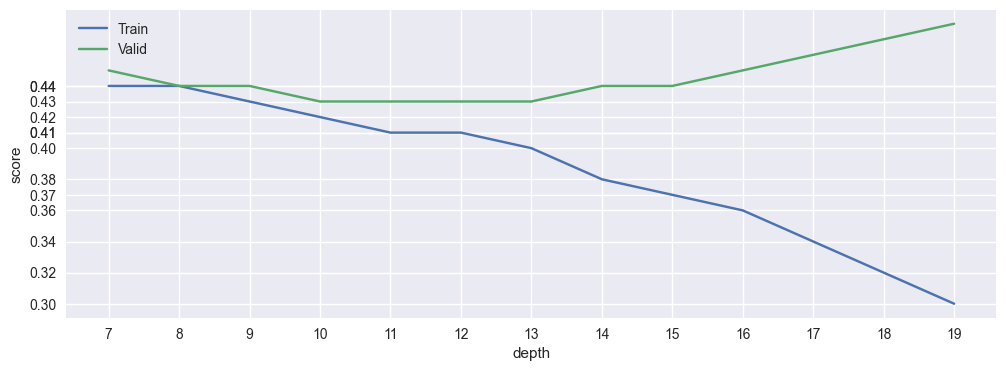

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4)) 

ax.plot(max_depths, train_scores, label='Train') 
ax.plot(max_depths, valid_scores, label='Valid') 

ax.set_xlabel('depth') 
ax.set_ylabel('score') 
ax.set_xticks(max_depths) 
ax.set_yticks(train_scores)
ax.legend()

In [ ]:
dtree = tree.DecisionTreeRegressor(max_depth=12, random_state=42) 
dtree.fit(X_train, y_train_log)

ypred_tr = dtree.predict(X_train)
ypred_vl = dtree.predict(X_valid)

rmsle(y_train_log, ypred_tr), rmsle(y_valid_log, ypred_vl)

(0.41, 0.43)

In [ ]:
rfr = ens.RandomForestRegressor(n_estimators=200, max_depth=12,
                                criterion='squared_error', min_samples_split=20,
                                random_state=42, verbose=True)
rfr.fit(X_train, y_train_log)

ypred_tr = rfr.predict(X_train)
ypred_vl = rfr.predict(X_valid)

rmsle(y_train_log, ypred_tr), rmsle(y_valid_log, ypred_vl)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 26.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.8s finished


(0.4, 0.41)

In [ ]:
gbr = ens.GradientBoostingRegressor(learning_rate=0.5, n_estimators=100,
                                    max_depth=6, min_samples_split=30,
                                    random_state=42, verbose=True)

gbr.fit(X_train, y_train_log)

ypred_tr = gbr.predict(X_train)
ypred_vl = gbr.predict(X_valid)

rmsle(y_train_log, ypred_tr), rmsle(y_valid_log, ypred_vl)

      Iter       Train Loss   Remaining Time 
         1           0.3110           10.15m
         2           0.2247           10.00m
         3           0.1987            9.95m
         4           0.1876            9.80m
         5           0.1823            9.73m
         6           0.1783            9.60m
         7           0.1756            9.52m
         8           0.1730            9.40m
         9           0.1709            9.26m
        10           0.1696            9.14m
        20           0.1577            7.97m
        30           0.1538            6.92m
        40           0.1502            5.89m
        50           0.1480            4.88m
        60           0.1451            3.90m
        70           0.1431            2.90m
        80           0.1410            1.94m
        90           0.1393           57.92s
       100           0.1383            0.00s


(0.37, 0.39)

<AxesSubplot: xlabel='coefs', ylabel='feats'>

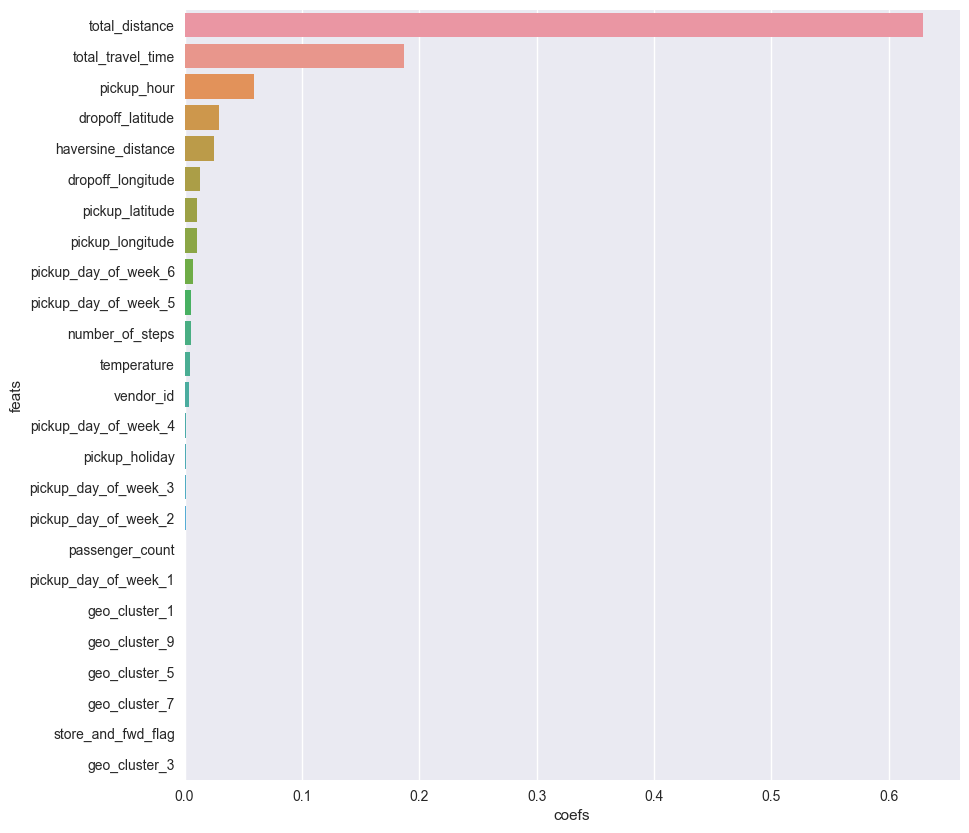

In [ ]:
feats_coefs = pd.DataFrame({'feats': gbr.feature_names_in_, 
                            'coefs': gbr.feature_importances_})

feats_coefs.sort_values(by='coefs', ascending=False, inplace=True)

plt.figure(figsize=(10, 10))
sns.barplot(feats_coefs, x='coefs', y='feats', orient='h')

In [ ]:
y_valid = np.exp(y_valid_log)-1 
ypred_vl = np.exp(ypred_vl)-1 

meae = m.median_absolute_error(y_valid, ypred_vl)

round(meae/60, 1)

1.8

## Финал

In [ ]:
test_data = pd.read_csv("data/Project5_test_data.zip")
osrm_test = pd.read_csv("data/Project5_osrm_data_test.zip")

In [ ]:
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holidays)
test_data = add_osrm_features(test_data, osrm_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = ohe.fit_transform(test_data[['pickup_day_of_week', 'geo_cluster', 'events']])
column_names = ohe.get_feature_names_out()
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat([test_data.reset_index(drop=True).drop(['pickup_day_of_week', 
                                                              'geo_cluster', 
                                                              'events'], axis=1), test_data_onehot], axis=1)

X_test = test_data[skb_feats]
X_test_scaled = mm_scaler.transform(X_test)

X_test = pd.DataFrame(X_test_scaled, columns=skb_feats)

X_test

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0             0.0         0.142857          0.791203         0.636454   
1             0.0         0.142857          0.791598         0.631256   
2             0.0         0.142857          0.791050         0.637009   
3             1.0         0.142857          0.791732         0.640436   
4             0.0         0.142857          0.791499         0.639395   
...           ...              ...               ...              ...   
625129        0.0         0.142857          0.790950         0.635762   
625130        0.0         0.142857          0.790902         0.637628   
625131        0.0         0.285714          0.791465         0.639234   
625132        0.0         0.142857          0.791395         0.636607   
625133        1.0         0.285714          0.791307         0.634941   

        dropoff_longitude  dropoff_latitude  store_and_fwd_flag  pickup_hour  \
0                0.791169          0.731039                 0.0          1.0   
1                0.791671          0.722405                 0.0          1.0   
2                0.791236          0.728724                 0.0          1.0   
3                0.791231          0.728804                 0.0          1.0   
4                0.791642          0.730971                 0.0          1.0   
...                   ...               ...                 ...          ...   
625129           0.790987          0.729075                 0.0          0.0   
625130           0.791776          0.733237                 0.0          0.0   
625131           0.793044          0.730356                 0.0          0.0   
625132           0.793412          0.742556                 0.0          0.0   
625133           0.791513          0.732121                 0.0          0.0   

        pickup_holiday  total_distance  ...  pickup_day_of_week_2  \
0                  0.0        0.043147  ...                   0.0   
1                  0.0        0.033015  ...                   0.0   
2                  0.0        0.017044  ...                   0.0   
3                  0.0        0.079839  ...                   0.0   
4                  0.0        0.012597  ...                   0.0   
...                ...             ...  ...                   ...   
625129             1.0        0.013257  ...                   0.0   
625130             1.0        0.108804  ...                   0.0   
625131             1.0        0.107897  ...                   0.0   
625132             1.0        0.270189  ...                   0.0   
625133             1.0        0.094011  ...                   0.0   

        pickup_day_of_week_3  pickup_day_of_week_4  pickup_day_of_week_5  \
0                        1.0                   0.0                   0.0   
1                        1.0                   0.0                   0.0   
2                        1.0                   0.0                   0.0   
3                        1.0                   0.0                   0.0   
4                        1.0                   0.0                   0.0   
...                      ...                   ...                   ...   
625129                   0.0                   1.0                   0.0   
625130                   0.0                   1.0                   0.0   
625131                   0.0                   1.0                   0.0   
625132                   0.0                   1.0                   0.0   
625133                   0.0                   1.0                   0.0   

        pickup_day_of_week_6  geo_cluster_1  geo_cluster_3  geo_cluster_5  \
0                        0.0            0.0            0.0            0.0   
1                        0.0            0.0            0.0            1.0   
2                        0.0            0.0            0.0            1.0   
3                        0.0            0.0            0.0            0.0   
4                        0.0            0.0

In [ ]:
test_id = test_data['id'] 

ypred_test = gbr.predict(X_test) 
ypred_test = np.exp(ypred_test)-1

submission = pd.DataFrame({'id': test_id, 'trip_duration': ypred_test})
submission.to_csv('data/submission_gb.csv', index=False)

submission

id  trip_duration
0       id3004672     847.187788
1       id3505355     533.855961
2       id1217141     378.614388
3       id2150126    1063.450649
4       id1598245     261.402579
...           ...            ...
625129  id3008929     329.690699
625130  id3700764    1194.238722
625131  id2568735    1663.191992
625132  id1384355    1953.631141
625133  id0621643    1086.236139

[625134 rows x 2 columns]

---

In [ ]:
import xgboost as xgb

# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=skb_feats)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=skb_feats)
dtest = xgb.DMatrix(X_test, feature_names=skb_feats)

In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 
            'objective': 'reg:squarederror'}

# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest))-1
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93577	valid-rmse:1.93572
[20]	train-rmse:0.78516	valid-rmse:0.78602
[30]	train-rmse:0.47918	valid-rmse:0.48121
[40]	train-rmse:0.42142	valid-rmse:0.42405
[50]	train-rmse:0.40929	valid-rmse:0.41237
[60]	train-rmse:0.40478	valid-rmse:0.40826
[70]	train-rmse:0.40168	valid-rmse:0.40561
[80]	train-rmse:0.39942	valid-rmse:0.40364
[90]	train-rmse:0.39752	valid-rmse:0.40209
[100]	train-rmse:0.39572	valid-rmse:0.40058
[110]	train-rmse:0.39410	valid-rmse:0.39932
[120]	train-rmse:0.39331	valid-rmse:0.39879
[130]	train-rmse:0.39201	valid-rmse:0.39783
[140]	train-rmse:0.39096	valid-rmse:0.39711
[150]	train-rmse:0.38999	valid-rmse:0.39655
[160]	train-rmse:0.38924	valid-rmse:0.39606
[170]	train-rmse:0.38852	valid-rmse:0.39567
[180]	train-rmse:0.38786	valid-rmse:0.39524
[190]	train-rmse:0.38716	valid-rmse:0.39492
[200]	train-rmse:0.38645	valid-rmse:0.39447
[210]	train-rmse:0.38563	valid-rmse:0.39400
[220]	train-rmse:0.38505	valid-rmse:0.39372

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1500x1500 with 0 Axes>

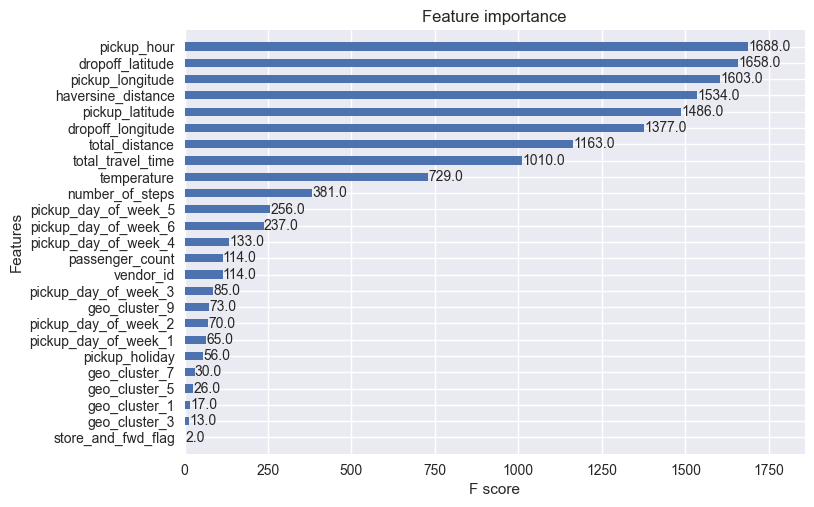

In [ ]:
xgb.plot_importance(model, height=0.5) 